## Historical weather data 

In [49]:
import pandas as pd
import time
from datetime import datetime
import random
import pytz

######## PARAMS TO BE SET ###############################

HOURLY_RESOURCE_ID = 'test_sarima_hourly'
DAILY_RESOURCE_ID = 'test_sarima_daily'
WAYLAY_PROFILE = 'aws-dev'
#########################################################

## download csv file from kaggle as `weatherHistory.csv`:
# https://www.kaggle.com/datasets/muthuj7/weather-dataset

In [87]:
from waylay.sdk import WaylayClient
client = WaylayClient.from_profile(WAYLAY_PROFILE)

In [51]:
## read csv file and keep relevant columns
df = pd.read_csv('weatherHistory.csv')

rename_cols = {"Formatted Date":"timestamp",
               "Temperature (C)": "temperature", 
               "Apparent Temperature (C)": "temp_feel",
               "Pressure (millibars)": "pressure",
               "Humidity": "humidity",
               "Wind Speed (km/h)": "wind_speed",
               "Summary": "description",
               "Precip Type": "type"
              }

df = df.rename(columns=rename_cols)
df = df[list(rename_cols.values())]
df["timestamp"] = pd.to_datetime(df["timestamp"], format='ISO8601', utc=True)
# # change description to lowercase only, as in OpenWeatherAPI
df["description"] = df["description"].apply(lambda x: x.lower())
df

,timestamp,temperature,temp_feel,pressure,humidity,wind_speed,description,type
0,2006-03-31 22:00:00+00:00,9.472222,7.388889,1015.13,0.89,14.1197,partly cloudy,rain
1,2006-03-31 23:00:00+00:00,9.355556,7.227778,1015.63,0.86,14.2646,partly cloudy,rain
2,2006-04-01 00:00:00+00:00,9.377778,9.377778,1015.94,0.89,3.9284,mostly cloudy,rain
3,2006-04-01 01:00:00+00:00,8.288889,5.944444,1016.41,0.83,14.1036,partly cloudy,rain
4,2006-04-01 02:00:00+00:00,8.755556,6.977778,1016.51,0.83,11.0446,mostly cloudy,rain
...,...,...,...,...,...,...,...,...
96448,2016-09-09 17:00:00+00:00,26.016667,26.016667,1014.36,0.43,10.9963,partly cloudy,rain
96449,2016-09-09 18:00:00+00:00,24.583333,24.583333,1015.16,0.48,10.0947,partly cloudy,rain
96450,2016-09-09 19:00:00+00:00,22.038889,22.038889,1015.66,0.56,8.9838,partly cloudy,rain
96451,2016-09-09 20:00:00+00:00,21.522222,21.522222,1015.95,0.60,10.5294,partly cloudy,rain


In [77]:
## we'll move timestamps up to today
last_time =  time.time()*1000
last_time = pd.Timestamp(last_time, unit='ms',tz='utc')

In [53]:
# ... or alternatively to the first timestamp that is currently available on waylay
loaded = await client.data.series.get_metric_series(
    HOURLY_RESOURCE_ID, 'temperature',
    query={'from':'2020-08-01T00:00:00Z','grouping':'P1D','aggregate':'count'}
)
last_time = pd.to_datetime(
    next(ts for [ts, count] in loaded.series if count is not None),
    unit='ms', utc=True
)
last_time

StopIteration: 

In [78]:
## change timestamps to window up until current time
## also add some noise to the timestamps

last_data_time = df["timestamp"].max()
print(f"last_data_time: {last_data_time} ({pd.Timestamp(last_data_time, unit='ms')})")
print(f"     last_time: {last_time} ({pd.Timestamp(last_time, unit='ms')})")
TIME_SHIFT = last_time - last_data_time

tz = pytz.timezone('Europe/Brussels')

df["timestamp"] = df["timestamp"].apply(
    lambda x: x + TIME_SHIFT + pd.Timedelta(int(random.uniform(-5000, +5000)),unit='ms')
)

last_data_time = df["timestamp"].max()
print(f"updated last_data_time: {last_data_time} ({pd.Timestamp(last_data_time, unit='ms')})")
df

last_data_time: 2016-12-31 22:00:00+00:00 (2016-12-31 22:00:00+00:00)
     last_time: 2025-04-28 11:58:32.911695068+00:00 (2025-04-28 11:58:32.911695068+00:00)
updated last_data_time: 2025-04-28 11:58:35.047695068+00:00 (2025-04-28 11:58:35.047695068+00:00)


,timestamp,temperature,temp_feel,pressure,humidity,wind_speed,description,type
0,2014-07-27 11:58:35.449695068+00:00,9.472222,7.388889,1015.13,0.89,14.1197,partly cloudy,rain
1,2014-07-27 12:58:37.144695068+00:00,9.355556,7.227778,1015.63,0.86,14.2646,partly cloudy,rain
2,2014-07-27 13:58:30.186695068+00:00,9.377778,9.377778,1015.94,0.89,3.9284,mostly cloudy,rain
3,2014-07-27 14:58:37.629695068+00:00,8.288889,5.944444,1016.41,0.83,14.1036,partly cloudy,rain
4,2014-07-27 15:58:37.141695068+00:00,8.755556,6.977778,1016.51,0.83,11.0446,mostly cloudy,rain
...,...,...,...,...,...,...,...,...
96448,2025-01-05 06:58:37.241695068+00:00,26.016667,26.016667,1014.36,0.43,10.9963,partly cloudy,rain
96449,2025-01-05 07:58:31.115695068+00:00,24.583333,24.583333,1015.16,0.48,10.0947,partly cloudy,rain
96450,2025-01-05 08:58:34.482695068+00:00,22.038889,22.038889,1015.66,0.56,8.9838,partly cloudy,rain
96451,2025-01-05 09:58:33.522695068+00:00,21.522222,21.522222,1015.95,0.60,10.5294,partly cloudy,rain


In [79]:
## add resource column and
df_hourly = df.copy().set_index('timestamp')
df_hourly['resource'] = HOURLY_RESOURCE_ID
df_hourly

,temperature,temp_feel,pressure,humidity,wind_speed,description,type,resource
timestamp,,,,,,,,
2014-07-27 11:58:35.449695068+00:00,9.472222,7.388889,1015.13,0.89,14.1197,partly cloudy,rain,test_sarima_hourly
2014-07-27 12:58:37.144695068+00:00,9.355556,7.227778,1015.63,0.86,14.2646,partly cloudy,rain,test_sarima_hourly
2014-07-27 13:58:30.186695068+00:00,9.377778,9.377778,1015.94,0.89,3.9284,mostly cloudy,rain,test_sarima_hourly
2014-07-27 14:58:37.629695068+00:00,8.288889,5.944444,1016.41,0.83,14.1036,partly cloudy,rain,test_sarima_hourly
2014-07-27 15:58:37.141695068+00:00,8.755556,6.977778,1016.51,0.83,11.0446,mostly cloudy,rain,test_sarima_hourly
...,...,...,...,...,...,...,...,...
2025-01-05 06:58:37.241695068+00:00,26.016667,26.016667,1014.36,0.43,10.9963,partly cloudy,rain,test_sarima_hourly
2025-01-05 07:58:31.115695068+00:00,24.583333,24.583333,1015.16,0.48,10.0947,partly cloudy,rain,test_sarima_hourly
2025-01-05 08:58:34.482695068+00:00,22.038889,22.038889,1015.66,0.56,8.9838,partly cloudy,rain,test_sarima_hourly


In [80]:
## save dataframe to csv file
df_hourly.to_csv("recentWeatherHistoryHourly.csv")


## upload for import with https://console-aws.dev.waylay.io/storage/buckets/etl-import/upload 

In [81]:
df_daily = df_hourly.iloc[::24, :].copy()
df_daily['resource'] = DAILY_RESOURCE_ID
df_daily

,temperature,temp_feel,pressure,humidity,wind_speed,description,type,resource
timestamp,,,,,,,,
2014-07-27 11:58:35.449695068+00:00,9.472222,7.388889,1015.13,0.89,14.1197,partly cloudy,rain,test_sarima_daily
2014-08-05 11:58:37.680695068+00:00,10.422222,10.422222,1014.40,0.62,16.9855,partly cloudy,rain,test_sarima_daily
2014-08-06 11:58:37.321695068+00:00,13.772222,13.772222,1007.36,0.60,17.0982,overcast,rain,test_sarima_daily
2014-08-07 11:58:36.254695068+00:00,8.200000,5.072222,1004.80,0.96,20.4470,foggy,rain,test_sarima_daily
2014-08-08 11:58:28.982695068+00:00,7.316667,6.211111,1007.07,0.75,6.6654,mostly cloudy,rain,test_sarima_daily
...,...,...,...,...,...,...,...,...
2024-12-31 14:58:35.142695068+00:00,16.772222,16.772222,1012.62,0.81,6.3434,mostly cloudy,rain,test_sarima_daily
2025-01-01 14:58:33.568695068+00:00,12.800000,12.800000,1014.16,0.96,6.5205,partly cloudy,rain,test_sarima_daily
2025-01-02 14:58:28.045695068+00:00,17.200000,17.200000,1021.69,0.93,14.0231,mostly cloudy,rain,test_sarima_daily


In [82]:
df_daily.to_csv("recentWeatherHistoryDaily.csv")

## upload for import with https://console-aws.dev.waylay.io/storage/buckets/etl-import/upload 

In [ ]:

NM_RES = [
    ["sarimaWeatherHistoryHourly", HOURLY_RESOURCE_ID],
    ["sarimaWeatherHistoryDaily", DAILY_RESOURCE_ID]
]
for [name, resource] in NM_RES:
    query_def  = {
      "name": name,
      "query": {
        "resource": resource,
        "until": "now",
        "from": "-P5D",
        "data": [
          {
            "metric": "temperature",
            "aggregation": "mean"
          },
          {
            "metric": "temp_feel",
            "aggregation": "mean"
          },
          {
            "metric": "pressure",
            "aggregation": "mean"
          },
          {
            "metric": "wind_speed",
            "aggregation": "mean"
          },
          {
            "metric": "humidity",
            "aggregation": "mean"
          }
        ]
      }
    }
    res = await client.queries.manage.create(json=query_def)
    print(f'{name} query:\n\t{res.query}\n')
    

In [104]:
[ data_set ] = await client.queries.execute.execute_by_name(
    'sarimaWeatherHistoryHourly', query={ 'from':'-P14D' }, select_path='data', response_type=list, timeout=10.0
)

<Axes: xlabel='timestamp'>

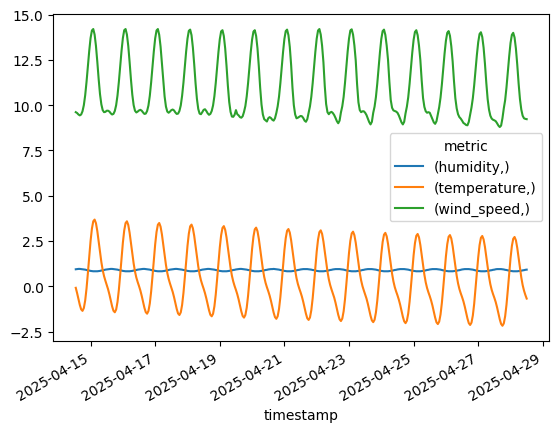

In [126]:
df = pd.DataFrame(data_set['data']).set_index(0)
df.index=pd.to_datetime(df.index, unit='ms', utc=True)
df.index.name=data_set['columns'][0]
col_attrs = data_set['columns'][1:]
col_names=['metric']
col_tuples=[ [ col[n] for n in col_names] for col in col_attrs ]
df.columns=pd.MultiIndex.from_tuples(col_tuples, names=col_names )
df[['humidity','temperature','wind_speed']].plot()

<Axes: xlabel='timestamp'>

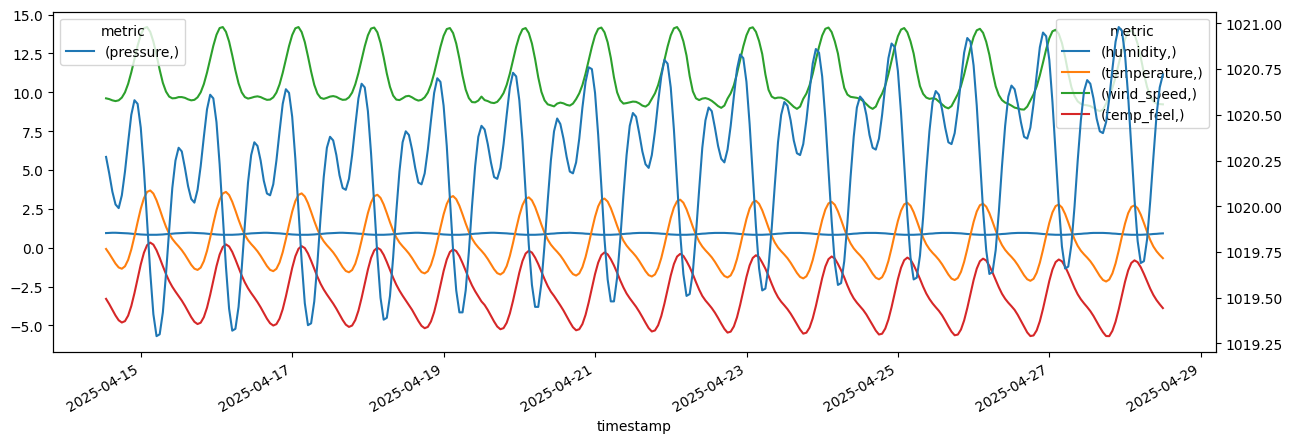

In [133]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
df[['humidity','temperature','wind_speed', 'temp_feel']].plot(ax=ax1)
ax2 = ax1.twinx()
df[['pressure']].plot(ax=ax2)
